In [1]:
# Import 
import os
import time
import json
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet#, SheetGeometry as geom
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.delamination_events import constriction

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

#from tyssue.solvers.quasistatic import QSSolver
#solver = QSSolver(with_t1=False, with_t3=False, with_collisions=True)

In [2]:
from tyssue.utils.utils import _to_3d, to_nd
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory

class RadialTension(effectors.AbstractEffector):

    dimensions = units.line_tension
    magnitude = 'radial_tension'
    label = 'Apical basal tension'
    element = 'vert'
    specs = {'vert': {'is_active',
                      'height',
                      'radial_tension'}}

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            'height * radial_tension * is_active')

    @staticmethod
    def gradient(eptm):
        grad = height_grad(eptm) * to_nd(
            eptm.vert_df.eval('radial_tension'), 3)
        grad.columns = ['g' + c for c in eptm.coords]
        return grad, None

model = model_factory(
    [
        RadialTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/2019-05-26')
today = datetime.date.today()

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0):

    h5store = '../examples/superegg.hf5'
    #h5store = '../data/hf5/small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    with open('../examples/superegg.json', 'r+') as fp:
        specs = json.load(fp)
    sheet = Sheet('fold', datasets, specs)
    sheet.sanitize()
    geom.update_all(sheet)
    sheet.vert_df['radial_tension']=0
    sheet.edge_df['opposite'] = sheet.get_opposite()
    sheet.settings['lumen_vol'] = 837809.9534519882
    sheet.settings["lumen_prefered_vol"]= sheet.settings["lumen_vol"]*1.1
    sheet.settings["lumen_vol_elasticity"]= 1e-1/sheet.Nf
    sheet.settings["threshold_length"]= 1e-2
    sheet.face_df.contractility=1.12
    return sheet

sheet = load_before_apopto(0)

geom.update_all(sheet)



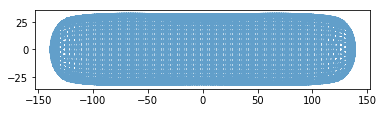

In [5]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)




In [6]:
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.279566, 0.067836, 0.391917],
       [0.267004, 0.004874, 0.329415],
       [0.269944, 0.014625, 0.341379],
       ...,
       [0.458674, 0.816363, 0.329727],
       [0.449368, 0.813768, 0.335384],
       [0.404001, 0.800275, 0.362552]]), lines=array([[   0,  258],
       [3049, 3046],
       [1971, 3049],
       ...,
       [1583, 1582],
       [ 685, 1157],
       [3737, 3734]], dtype=uint32), texture=None, x=array([-134.37105265,  -51.10586247, -138.16179393, ...,  -46.98972015,
        -42.84954213,  -44.92076762]), y=array([-18.43630285,  32.05116934,   7.10904242, ..., -19.76812135,
       -19.72467399, -20.67988498]), z=array([ 1.45674271, -5.43773581,  0.28894134, ..., 25.76565617,
       25.71321792, 24.9933467 ]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-152.56613672526979, 152.59974721361755], ylim=[-152.56613672526979, 152.59974721361755], zlim=[-152.56613672526979, 152.59974721361755])

In [7]:
"""
Mesoderm invagination event module
=======================


"""

import random
import numpy as np

from tyssue.utils.decorators import face_lookup
from tyssue.behaviors.sheet.actions import relax, contract, ab_pull
from tyssue.behaviors.sheet.basic_events import contraction


default_constriction_spec = {
    "face_id": -1,
    "face": -1,
    "contract_rate": 2,
    "critical_area": 1e-2,
    "radial_tension": 1.0,
    "contract_neighbors": True,
    "critical_area_neighbors": 10,
    "contract_span": 2,
    "basal_contract_rate": 1.001,
    "current_traction": 0,
    "max_traction": 30,
    "contraction_column": "contractility",
}


@face_lookup
def delamination(sheet, manager, **kwargs):
    """Constriction process
    This function corresponds to the process called "apical constriction"
    in the manuscript
    The cell undergoing delamination first contracts its apical
    area until it reaches a critical area. A probability
    dependent to the apical area allow an apico-basal
    traction of the cell. The cell can pull during max_traction
    time step, not necessarily consecutively.
    Parameters
    ----------
    sheet : a :class:`tyssue.sheet` object
    manager : a :class:`tyssue.events.EventManager` object
    face_id : int
       the Id of the face undergoing delamination.
    contract_rate : float, default 2
       rate of increase of the face contractility.
    critical_area : float, default 1e-2
       face's area under which the cell starts loosing sides.
    radial_tension : float, default 1.
       tension applied on the face vertices along the
       apical-basal axis.
    contract_neighbors : bool, default `False`
       if True, the face contraction triggers contraction of the neighbor
       faces.
    contract_span : int, default 2
       rank of neighbors contracting if contract_neighbor is True. Contraction
       rate for the neighbors is equal to `contract_rate` devided by
       the rank.
    """
    constriction_spec = default_constriction_spec
    constriction_spec.update(**kwargs)

    # initialiser une variable face
    # aller chercher la valeur dans le dictionnaire à chaque fois ?
    face = constriction_spec["face"]
    contract_rate = constriction_spec["contract_rate"]
    current_traction = constriction_spec["current_traction"]

    
    
    face_area = sheet.face_df.loc[face, "area"]

    if face_area > constriction_spec["critical_area"]:
        contract(
            sheet,
            face,
            contract_rate,
            True,
            constriction_spec["contraction_column"],
        )
        # if sheet.face_df.loc[face, 'prefered_area'] > 6:
        #    sheet.face_df.loc[face, 'prefered_area'] -= 0.5
        # increase_linear_tension(sheet, face, contract_rate)

        if (constriction_spec["contract_neighbors"]) & (
            face_area < constriction_spec["critical_area_neighbors"]
        ):
            neighbors = sheet.get_neighborhood(
                face, constriction_spec["contract_span"]
            ).dropna()
            neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values

            manager.extend(
                [
                    (
                        contraction,
                        _neighbor_contractile_increase(neighbor, constriction_spec),
                    )  # TODO: check this
                    for _, neighbor in neighbors.iterrows()
                ]
            )

    proba_tension = np.exp(-face_area / constriction_spec["critical_area"])
    aleatory_number = random.uniform(0, 1)
    if current_traction < constriction_spec["max_traction"]:
        if aleatory_number < proba_tension:
            current_traction = current_traction + 1
            ab_pull(sheet, face, constriction_spec["radial_tension"], True)
            constriction_spec.update({"current_traction": current_traction})

    manager.append(delamination, **constriction_spec)


def _neighbor_contractile_increase(neighbor, constriction_spec):

    contract = constriction_spec["contract_rate"]
    basal_contract = constriction_spec["basal_contract_rate"]

    increase = (
        -(contract - basal_contract) / constriction_spec["contract_span"]
    ) * neighbor["order"] + contract

    specs = {
        "face_id": neighbor["id"],
        "contractile_increase": increase,
        "critical_area": constriction_spec["critical_area"],
        "max_contractility": 50,
        "contraction_column": constriction_spec["contraction_column"],
        "multiple": True,
        "unique": False,
    }

    return specs


In [8]:
#Add clone cell
#clone of 5 cells

sheet.face_df['is_mesoderm']=0
index_clone_cells = sheet.face_df[(sheet.face_df.z>15) & (sheet.face_df.z<24) 
              & (sheet.face_df.y>25) & (sheet.face_df.y<35) 
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1

number of apoptotic cells: 26
id apoptotic cells :  [ 757 1865   47 2544   78  605   46 1469  334 2690  336 2331  546  906
 2040 2516 1060  268 1508  711 2724 1531  233 1530  630  111]


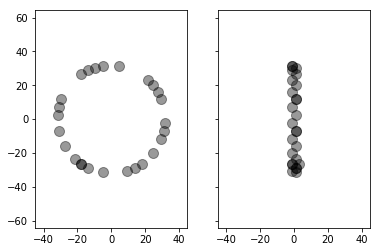

In [9]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=1.8, amp=0.4):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(sheet):

    np.random.seed(40)
    sheet.face_df['theta'] = np.arctan2(sheet.face_df['x'],
                                        sheet.face_df['y'])
    
    p_apopto = apopto_pdf(sheet.face_df['z'], sheet.face_df['theta'])
    rand_field = np.random.random(sheet.face_df.shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in sheet.face_df.loc[apopto_cells].sort_values('x').index
                             if sheet.face_df.loc[c, 'is_alive']])
    return apopto_cells

apopto_cells = get_apopto_cells(sheet)
print('number of apoptotic cells: {}'.format(apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[apopto_cells, 'x'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);
print ('id apoptotic cells : ', apopto_cells)

In [10]:
def apoptosis_time_table(sheet,
                         apoptotic_cell,
                         start_t=0):

    settings = {
        'shrink_steps': 10,
        'rad_tension': 2.0,
        'contractile_increase': 2.0,
        'contract_span': 3
        }
    shrink_steps = settings['shrink_steps']
    rad_tension = settings['rad_tension']
    contractile_increase = settings['contractile_increase']
    contract_span = settings['contract_span']

    apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]

    n_sides = apoptotic_edges.shape[0]
    # Number of type 1 transitions to solve the rosette
    n_type1 = n_sides - 3
    end_shrink = start_t + shrink_steps
    end_t = start_t + shrink_steps + n_type1

    times = range(start_t, end_t+1)
    shrink_times = range(start_t, end_shrink)

    cell_time_idx = pd.MultiIndex.from_tuples(
        [(t, apoptotic_cell) for t in times],
        names=['t', 'face'])

    time_table = pd.DataFrame(index=cell_time_idx,
                              columns=['start'])

    pref_vols = np.logspace(0., -4., shrink_steps)
    time_table.loc[start_t, 'start'] = 1

    


    return times, time_table.sort_index()

def get_time_table(sheet, apopto_cells):

    time_tables = []
    for strat_t, cell in enumerate(apopto_cells):

        times, time_table = apoptosis_time_table(sheet, cell, start_t=strat_t)
        time_tables.append(time_table)
    time_table = pd.concat(time_tables).sort_index()
    times = time_table.index.levels[0]
    return times, time_table

times, time_table = get_time_table(sheet, apopto_cells)



In [11]:
# Get moment where apoptotic cell need to start. 
start_apoptosis={}
for t in time_table.itertuples():
    if t.Index[1] not in start_apoptosis:
        start_apoptosis[t.Index[1]]=t.Index[0]
len(start_apoptosis)
# start_apoptosis : key = face, value = time

def invert_dico(dico):
    new_dico={}
    for (face, time) in start_apoptosis.items():
        new_dico[time]=face
    return new_dico

start_apoptosis=invert_dico(start_apoptosis)

In [12]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                              'options': {'ftol': 1e-8,
                                          'gtol': 1e-8}}}
res = solver.find_energy_min(sheet, geom, model, **solver_kw)
print(res['success'])

True


In [13]:
import random
from tyssue.utils.decorators import face_lookup
from tyssue.geometry.sheet_geometry import SheetGeometry

from tyssue.behaviors.sheet.actions import contract, ab_pull, exchange, remove, contract
from tyssue.behaviors.sheet.basic_events import contraction

default_apoptosis_spec = {
    "face_id": -1,
    "face": -1,
    "critical_area": 1e-2,
    "radial_tension": 0.1,
    "contract_rate": 0.1,
    "basal_contract_rate": 1.001,
    "contract_span": 2,
    "max_traction":30,
    "current_traction":0,
    "geom": SheetGeometry,
}


@face_lookup
def apoptosis(sheet, manager, **kwargs):
    """Apoptotic behavior

    While the cell's apical area is bigger than a threshold, the
    cell contracts, and the contractility of its neighbors is increased.
    once the critical area is reached, the cell is eliminated
    from the apical surface through successive type 1 transition. Once
    only three sides are left, the cell is eliminated from the tissue.

    Parameters
    ----------
    sheet : a :class:`Sheet` object
    manager : a :class:`EventManager` object
    face_id : int,
        the id of the apoptotic cell
    contract_rate : float, default 0.1
        the rate of reduction of the cell's prefered volume
        e.g. the prefered volume is devided by a factor 1+contract_rate
    critical_area : area at which the face is eliminated from the sheet
    radial_tension : amount of radial tension added at each contraction steps
    contractile_increase : increase in contractility at the cell neighbors
    contract_span : number of neighbors affected by the contracitity increase
    geom : the geometry class used
    """

    apoptosis_spec = default_apoptosis_spec
    apoptosis_spec.update(**kwargs)
    
    # Small variable name for some spec
    face = apoptosis_spec["face"]
    contract_rate = apoptosis_spec["contract_rate"]
    basal_contract = apoptosis_spec["basal_contract_rate"]
    current_traction = apoptosis_spec["current_traction"]
    face_area = sheet.face_df.loc[face, "area"]
    
    if face_area > apoptosis_spec["critical_area"]:
        # contract
        contract(sheet, face, apoptosis_spec["contract_rate"], True)
        # contract neighbors
        neighbors = sheet.get_neighborhood(
            face, apoptosis_spec["contract_span"]
        ).dropna()
        neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values
        
        manager.extend(
        [
            (
                contraction,
                _neighbor_contractile_increase(neighbor, apoptosis_spec),
            )
            for _, neighbor in neighbors.iterrows()
        ])
                
        done = False
    else:
        if sheet.face_df.loc[face, "num_sides"] > 3:
            exchange(sheet, face, apoptosis_spec["geom"])
            done = False
        else:
            if current_traction >= apoptosis_spec["max_traction"]:
                remove(sheet, face, apoptosis_spec["geom"])
                done = True
       
    
    proba_tension = np.exp(-face_area / apoptosis_spec["critical_area"])
    aleatory_number = random.uniform(0, 1)
    if current_traction < apoptosis_spec["max_traction"]:
        if aleatory_number < proba_tension:
            current_traction = current_traction + 1
            ab_pull(sheet, face, apoptosis_spec["radial_tension"], distributed=False)
            apoptosis_spec.update({"current_traction": current_traction})
    
    if not done:
        manager.append(apoptosis, **apoptosis_spec)

        
def _neighbor_contractile_increase(neighbor, apoptosis_spec):

    contract = apoptosis_spec["contract_rate"]
    basal_contract = apoptosis_spec["basal_contract_rate"]

    increase = (
        -(contract - basal_contract) / apoptosis_spec["contract_span"]
    ) * neighbor["order"] + contract

    specs = {
        "face_id": neighbor["id"],
        "contractile_increase": increase,
        "critical_area": apoptosis_spec["critical_area"],
        "max_contractility": 50,
        "multiple": True,
        "unique": False,
    }

    return specs

In [14]:
def run_sim(sim_save_dir, sheet, constriction, radial_tension,  iteration=0):
    
    dirname = '{}_constriction_{}_radialtension{}'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass

    
    apoptosis_settings = {
        "critical_area": 1e-2,
        "contract_rate": constriction,
        "basal_contract_rate": 1.001,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "geom": geom,
    }
    
    delaminate_settings = {'critical_area': 1e-2,
                'radial_tension': radial_tension*150/100,
                'nb_iteration': 0,
                'nb_iteration_max': 200,
                'contract_neighbors': True,
                'critical_area_neighbors': 12,
                'contract_span': 2,
                'basal_contract_rate': 1.001,
                'geom': geom,
                'contraction_column': 'contractility'}
    
    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    sheet2.settings['delamination'] = delaminate_settings
    
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    solver_kw = {'minimize': {'method': 'L-BFGS-B',
                              'options': {'ftol': 1e-8,
                                          'gtol': 1e-8}}}
    res = solver.find_energy_min(sheet2, geom, model, **solver_kw)

    sheet2 = apoptosis_process(dirname, solver, solver_kw, sheet2, geom, model)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [15]:
def apoptosis_process(dirname, solver, solver_kw, sheet, geom, model):
    
    # Initiate manager
    manager = EventManager('face')
    
    t = 0
    stop = 200
        
    for i in index_clone_cells:
        delamination_kwargs = sheet.settings['delamination'].copy()
        delamination_kwargs.update(
                {
                    'face_id': i,
                }
            )
        manager.append(delamination, **delamination_kwargs)
        
    # Run simulation
    while manager.current and t < stop:
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0
        
        # Add face in apoptosis according to the 
        # spatio-temporal patterning define previously
        if t in start_apoptosis:
            apopto_kwargs = sheet.settings['apoptosis'].copy()
            apopto_kwargs.update(
                {
                    'face_id': start_apoptosis[t],
                }
            )
            manager.append(apoptosis, **apopto_kwargs)
        
        
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)

        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        hdf5.save_datasets(hdfname, sheet)

        manager.update()
        t += 1

    return sheet


In [16]:
%pdb

Automatic pdb calling has been turned ON


In [17]:
"""# Sequential Execution

from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

radial_tension = [50, 0, 5, 10, 15, 20]

#for rd in radial_tension:
contractility_percent = [4, 8, 16, 32]
contractility_rate = [1+c/100 for c in contractility_percent]

for c in contractility_rate:
    for rd in radial_tension:
        for iteration in range (0, 1):
            run_sim(sim_save_dir, sheet, c, rd, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)"""

'# Sequential Execution\n\nfrom datetime import datetime\n\nglobal_start=datetime.now()\nprint ("start : " + str(global_start))\n\nradial_tension = [50, 0, 5, 10, 15, 20]\n\n#for rd in radial_tension:\ncontractility_percent = [4, 8, 16, 32]\ncontractility_rate = [1+c/100 for c in contractility_percent]\n\nfor c in contractility_rate:\n    for rd in radial_tension:\n        for iteration in range (0, 1):\n            run_sim(sim_save_dir, sheet, c, rd, iteration)\n        \n        \n        \nglobal_end = datetime.now()\nprint ("end : " + str(global_end))\nprint (\'Duree totale d execution : \n\t\t\')\nprint (global_end-global_start)'

In [18]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()

radial_tension = [ 50, 40, 30, 20]

#for rd in radial_tension:
contractility_percent = [2, 4, 8, 16, 32]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, sheet, c, rd, 0) 
                             for c, rd in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-05-25 22:52:47.367910
starting /home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_50_radialtension0
starting /home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_40_radialtension0


/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['opposite']]

/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['opposite']]



/home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_40_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_30_radialtension0
/home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_50_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_20_radialtension0
/home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_20_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

/home/admin-suz/Documents/Simulations/2019-05-26/1.08_constriction_30_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

end : 2019-05-26 04:27:45.549374
Duree totale d execution : 
		
5:34:58.181464
